<a href="https://colab.research.google.com/github/ssinad/covid-visualization/blob/main/Covid_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib notebook
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, curve_fit
import numpy as np
from pandas.plotting import register_matplotlib_converters
import pandas as pd

register_matplotlib_converters()

def func(x, a, b):
      return b * a ** x

In [2]:
def clean_data_1(df):
  df = pd.DataFrame({"Date": df.columns, "Number": df.values[0]})
  df = df.astype({"Date": np.datetime64, "Number": np.int64})
  stats = df[df["Number"] != 0]
  return stats


df = pd.read_csv("https://github.com/nytimes/covid-19-data/raw/master/us.csv", parse_dates=["date"])
df = df.iloc[:, 0:2]
us_stats = df.rename(columns={"date": "Date", "cases": "Number"})

global_stats = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
recovered = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

ab_stats = clean_data_1(global_stats[global_stats["Province/State"] == "Alberta"].iloc[:, 4:])
# print(recovered[recovered["Province/State"] == "Alberta"])
# ab_recovered = clean_data_2(recovered[recovered["Province/State"] == "Alberta"].iloc[:, 4:])

ontario_stats = clean_data_1(global_stats[global_stats["Province/State"] == "Ontario"].iloc[:, 4:])
# ontario_recovered = clean_data_2(recovered[recovered["Province/State"] == "Ontario"].iloc[:, 4:])

bc_stats = clean_data_1(global_stats[global_stats["Province/State"] == "British Columbia"].iloc[:, 4:])
# bc_recovered = clean_data_2(recovered[recovered["Province/State"] == "British Columbia"].iloc[:, 4:])

qc_stats = clean_data_1(global_stats[global_stats["Province/State"] == "Quebec"].iloc[:, 4:])
# qc_recovered = clean_data_2(recovered[recovered["Province/State"] == "Quebec"].iloc[:, 4:])

canada_stats = global_stats[global_stats["Country/Region"] == "Canada"].iloc[:, 4:].sum(axis=0)
canada_stats = pd.DataFrame({"Date": canada_stats.index, "Number": canada_stats.values})
canada_stats = canada_stats.astype({"Date": np.datetime64, "Number": np.int64})
# canada_stats = canada_stats[canada_stats["Number"] != 0]

canada_recovered = recovered[recovered["Country/Region"] == "Canada"].iloc[:, 4:]
canada_recovered = pd.DataFrame({"Date": canada_recovered.columns, "Number": canada_recovered.values[0]})
canada_recovered = canada_recovered.astype({"Date": np.datetime64, "Number": np.int64})
# canada_recovered = canada_recovered[canada_recovered["Number"] != 0]


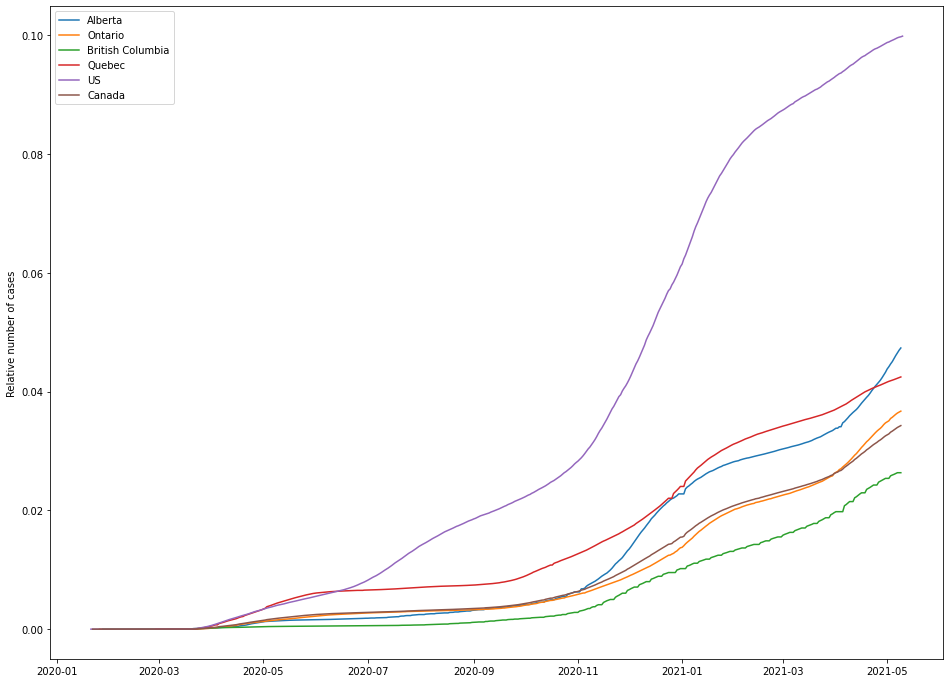

In [3]:
def relative_cases(stats, population, title=""):
  dates = [d.to_pydatetime() for d in stats.iloc[:, 0]]
  number = stats.iloc[:, 1]
  plt.plot(dates, number / population, label=title)


plt.figure(figsize=(16, 12))
relative_cases(ab_stats, population=4.41e6, title="Alberta")
relative_cases(ontario_stats, title="Ontario", population=13.6e6)
relative_cases(bc_stats, title="British Columbia", population=5.1e6)
relative_cases(qc_stats, title="Quebec", population=8433301)
relative_cases(us_stats, title="US", population=3.282e8)
relative_cases(canada_stats, title="Canada", population=37742154)


plt.legend()
plt.ylabel("Relative number of cases")
plt.show()

In [4]:
def beta_gamma(dates, cases, recovered, population):
  N = population
  R = recovered
  I = cases - recovered
  S = population - cases
  dcdt = np.gradient(cases)
  drdt = np.gradient(recovered)
  gamma = drdt / I
  beta = N * dcdt / I / S
  return beta, gamma
  

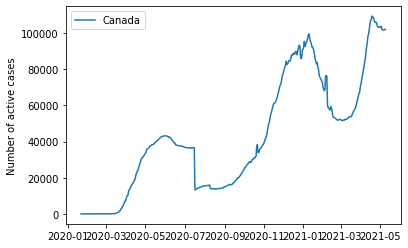

In [5]:
dates = [d.to_pydatetime() for d in canada_stats.iloc[:, 0]]
number = canada_stats.iloc[:, 1] - canada_recovered.iloc[:, 1]
plt.plot(dates, number, label="Canada")

plt.legend()
plt.ylabel("Number of active cases")
plt.show()

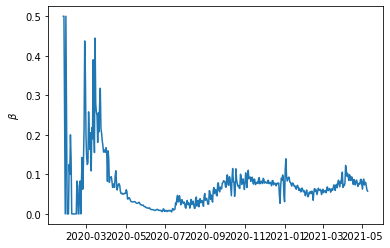

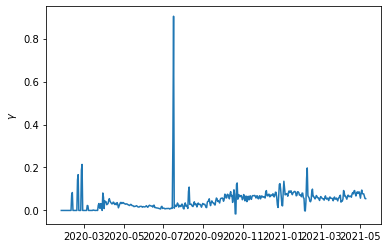

In [6]:
beta, gamma = beta_gamma(dates=dates, cases=canada_stats.iloc[:, 1], recovered=canada_recovered.iloc[:, 1], population=37742154)
plt.plot(dates, beta, label=r"$\beta$")
plt.ylabel(r"$\beta$")
plt.show()
plt.plot(dates, gamma, label=r"$\gamma$")
plt.ylabel(r"$\gamma$")

# plt.legend()
# plt.ylabel("Relative number of active cases")
plt.show()

In [7]:
def relative_new_cases(stats, population, title=""):
  dates = [d.to_pydatetime() for d in stats.iloc[:, 0]]
  number = np.gradient(stats.iloc[:, 1])
  plt.plot(dates, number / population, label=title)

# relative_new_cases(ab_stats, population=4.41e6, title="Alberta")
# relative_new_cases(ontario_stats, title="Ontario", population=13.6e6)
# relative_new_cases(bc_stats, title="British Columbia", population=5.1e6)
# relative_new_cases(qc_stats, title="Quebec", population=8433301)
# relative_new_cases(us_stats, title="US", population=3.282e8)
# plt.legend()
# plt.ylabel("Relative new cases")

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1068: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1089: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0


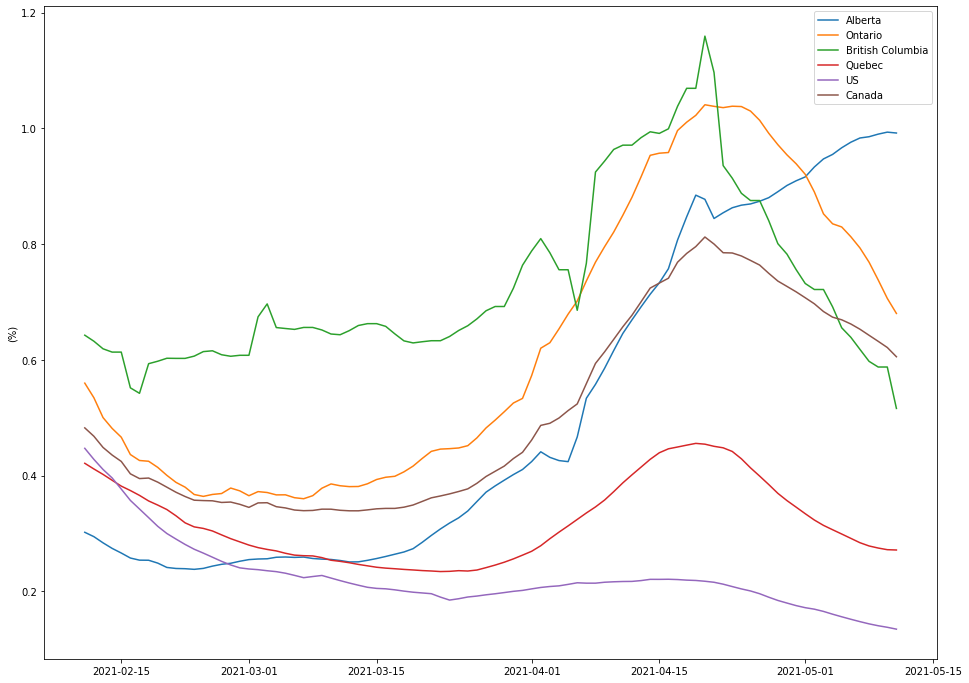

In [8]:
def rates_1(stats, title="", num_days=14):
  number = stats.iloc[:, 1]
  log_number = np.log(number)
                                    
  deriv = np.gradient(log_number, edge_order=1)                                            
  arr = np.zeros(len(deriv) - num_days + 1)
  for cnt in range(num_days):
    arr += deriv[cnt:len(deriv)-num_days+cnt + 1]
  arr /= num_days
  rate = np.exp(arr) - 1
  dates_from_today_1 = [date.today() - timedelta(days=len(rate) - 1) + timedelta(days=cnt) for cnt in range(len(rate))]
  plt.ylabel('(%)')
  plt.plot(dates_from_today_1[-90:], rate[-90:] * 100, label=title)


plt.figure(figsize=(16, 12))
rates_1(ab_stats, "Alberta")
rates_1(ontario_stats, "Ontario")
rates_1(bc_stats, "British Columbia")
rates_1(qc_stats, "Quebec")
rates_1(us_stats, "US")
rates_1(canada_stats, "Canada")
plt.legend()
plt.show()

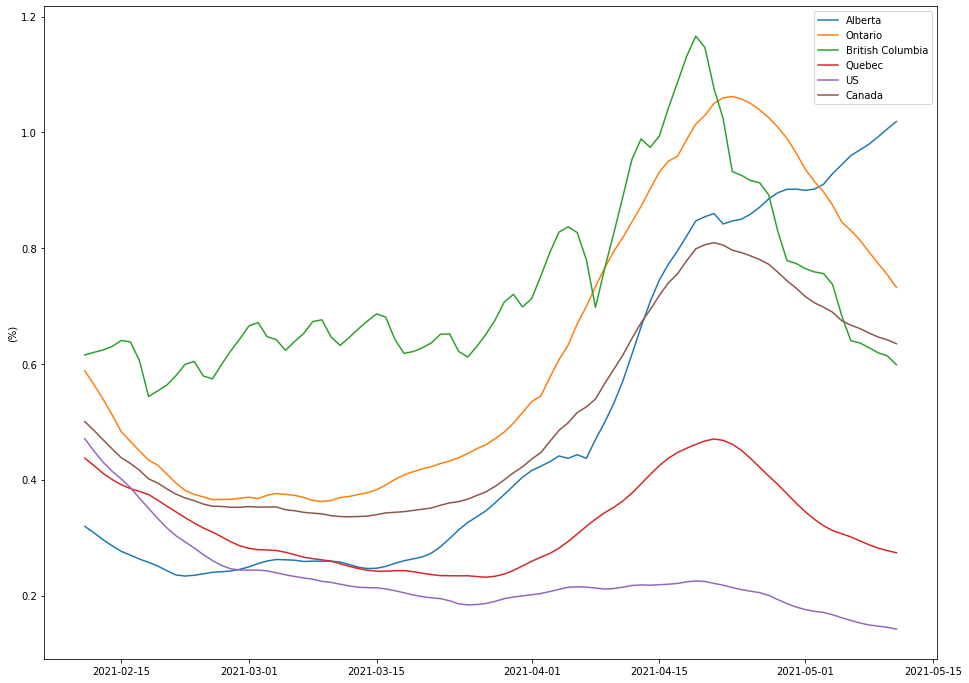

In [9]:
def rates_2(stats, title="", num_days=14):
  number = stats.iloc[:, 1]
  rate_2 = []
  for cnt in range(len(number) - num_days - 1):
    p = curve_fit(func, range(num_days + 1), number[cnt:cnt + num_days + 1])[0]
    rate_2.append(p[0] - 1)
  rate_2 = np.array(rate_2)
  dates_from_today_2 = [date.today() - timedelta(days=len(rate_2) - 1) + timedelta(days=cnt) for cnt in range(len(rate_2))]
  plt.ylabel('(%)')
  plt.plot(dates_from_today_2[-90:], rate_2[-90:] * 100, label=title)


plt.figure(figsize=(16, 12))
rates_2(ab_stats, "Alberta")
rates_2(ontario_stats, "Ontario")
rates_2(bc_stats, "British Columbia")
rates_2(qc_stats, "Quebec")
rates_2(us_stats, "US")
rates_2(canada_stats, "Canada")
plt.legend()
plt.show()